## Tutorial for exploring linearizers and linearized PTCs with the RSP

Written by **Jerónimo Calderón (RECA Intern 2022)** based on Notebooks provided by Craig Lage and Chris Waters.

Last modified Aug 17 2022, using Recommended Version Weekly 2022_22 of the Stack.

Importing useful libraries:

In [2]:
import sys, os, glob, time
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import astropy.io.fits as pf
from lsst.daf.butler import Butler
import lsst.afw.math as afwMath
from lsst.cp.pipe.utils import (funcPolynomial, irlsFit)

Now we need to call the butler to handle the data from the collections we generated/have access to. You want to change the route "u/jcalderong/reca/calib_13144_20220621" to your location for the calibration images.

In [3]:
butler = Butler("/repo/main", collections=["LSSTCam/raw/all","LSSTCam/calib",\
                                                    "u/jcalderong/reca/calib_13144_20220621"])
camera = butler.get('camera', instrument='LSSTCam')

Here we define a couple of useful functions for handling monitor diode data and doing exponential fits.

In [8]:
def ExpApprox(mu, g, a00, n):
    if (g < 1.0E-6) or (abs(a00) < 1.0E-9):
        return np.zeros([len(mu)])
    else:
        expFactor = 2.0 * a00 * mu * g
        if max(expFactor) > 100.0:
            return np.zeros([len(mu)])
        else:
            preFactor = 1.0 / (2.0 * g * g * a00)
            noiseTerm = n / (g * g)
            return preFactor * (np.exp(expFactor) - 1.0) + noiseTerm
        
def calcMondiode(expId):
    factor = 5.0
    DATA_DIR = '/lsstdata/offline/teststand/BOT/storage/'
    date = int(expId/100000)
    seq = expId - date * 100000
    date = date - 10000000
    file = DATA_DIR + '%d/MC_C_%d_%06d/Photodiode_Readings_%d_%06d.txt'%(date,date,seq,date,seq)

    x, y = np.recfromtxt(file).transpose()
    # Threshold for finding baseline current values:                                                                                                                                                         
    ythresh = (min(y) + max(y))/factor + min(y)
    # Subtract the median of the baseline values to get a calibrated                                                                                                                                         
    # current.                                                                                                                                                                                               
    y -= np.median(y[np.where(y < ythresh)])
    integral = sum((y[1:] + y[:-1])/2*(x[1:] - x[:-1]))
    return integral

To linearize the PTC we should have run a non-linearized one beforehand. 

With the location of both PTCs we can call the butler to handle data of both cases.

In [9]:
# PTC before applying linearizers:
nonlinPtcButler = Butler("/repo/main", collections=["u/jcalderong/reca/ptc_13144"])

# PTC after applying linearizers for Spline of 12 knots:
linPtcButler12 = Butler("/repo/main", collections=["u/jcalderong/reca/ptc_13144_spline12"])

Now we set a couple of parameters that could be useful later:

In [10]:
# Set parameters
minLinearAdu = 2000.0
maxLinearAdu = 20000.0
nSigmaClipLinear = 5.0
fitOrder = 12 # Number of spline knots

Now we use the following code to generate plots to visualize the quality of the linearizer, and compare it to the non-linearized PTC. Part of this code is taken from cp_pipe/linearity.py.

If you want to try it out on a PTC generated by yourself just generate the non-linearized and linearized butlers with the right location for your collection. 

First set the right expId, set i=0 or 1 if the detector you are using is either E2V or ITL, set the number of spline knots that were used in the cpLinearityCorrected.yaml file and the detector number you want to visualize. Take some time to check what the cycles are doing and change the features of the plots as you like:

ITL-74-C01-Not Linearized Gain=1.6511, A00=-1.52718e-06, Noise=6.54, Turnoff=86910.70
0
Average % residual non-lin:	 0.6098483789768816
ITL-74-C01-Linearized Gain=1.6446, A00=-1.63724e-06, Noise=6.99, Turnoff=86766.86
1
Average % residual lin:	 0.21474992981228752


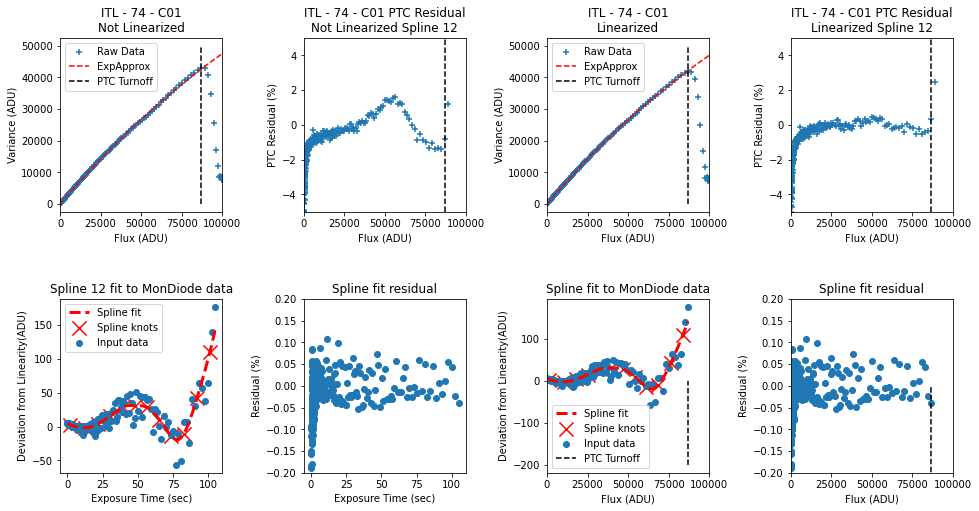

In [17]:
expId=3021120700200

names = ["E2V", "ITL"]
linNames = ["Not Linearized", "Linearized"]
i=1
spknots=12
det=74
linPtc = linPtcButler12.get('ptc', detector=det, exposure=expId, instrument='LSSTCam')
nonlinPtc = nonlinPtcButler.get('ptc', detector=det, exposure=expId, instrument='LSSTCam')
lin = linPtcButler12.get('linearizer', detector=det, exposure=expId, instrument='LSSTCam')
for amp in camera[0].getAmplifiers():
    ampName = amp.getName()
    if [det, ampName] not in [[74, 'C01']]:
        continue
    fig = plt.figure(figsize=(16,8))
    plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
    for n, ptc in enumerate([nonlinPtc, linPtc]):
        gain = ptc.gain[ampName]
        a00 = ptc.ptcFitPars[ampName][0]
        noise = ptc.noise[ampName]
        mask = np.array(ptc.expIdMask[ampName], dtype=bool)
        maxDM = np.max(np.array(ptc.rawMeans[ampName])[mask])
        print(f"{names[i]}-{det}-{ampName}-{linNames[n]} Gain={gain:.4f}, A00={a00:.6g}, Noise={noise:.2f}, Turnoff={maxDM:.2f}")
        yplot = ExpApprox(np.array(ptc.rawMeans[ampName]), gain, a00, noise)
        plt.subplot(2,4,2*n+1)
        plt.title(f"{names[i]} - {det} - {ampName}\n{linNames[n]}")
        plt.scatter(ptc.rawMeans[ampName], ptc.rawVars[ampName], marker='+', label="Raw Data")
        plt.plot(ptc.rawMeans[ampName], yplot, ls = '--', color = 'red', label = 'ExpApprox')
        plt.plot([maxDM, maxDM], [0, 50000], ls = '--', color='black', label = "PTC Turnoff")
        plt.legend()
        plt.xlim(0, 100000)
        plt.xticks([0,25000,50000,75000,100000])
        plt.xlabel("Flux (ADU)")
        plt.ylabel("Variance (ADU)")
        #plt.ylim(30000, 40000)
        plt.subplot(2,4,2*n+2)
        plt.title(f"{names[i]} - {det} - {ampName} PTC Residual\n{linNames[n]} Spline {spknots}")
        flux=np.array(ptc.rawMeans[ampName])
        ptcresiduals=yplot - ptc.rawVars[ampName]
        plt.scatter(flux, (ptcresiduals)*100/yplot, marker='+', label="Raw")
        print(n)
        if n==0:
            print("Average % residual non-lin:\t",np.average(np.abs((ptcresiduals[(flux<maxDM)&(flux>10000.)])*100/yplot[(flux<maxDM)&(flux>10000.)])))
        else:
            print("Average % residual lin:\t",np.average(np.abs((ptcresiduals[(flux<maxDM)&(flux>10000.)])*100/yplot[(flux<maxDM)&(flux>10000.)])))
        plt.plot([maxDM, maxDM], [-5, 5], ls = '--', color='black', label = "PTC Turnoff")
        plt.xlim(0,100000)
        plt.xticks([0,25000,50000,75000,100000])
        plt.ylim(-5,5)
        plt.xlabel("Flux (ADU)")
        plt.ylabel("PTC Residual (%)")

    # Now get and plot the linearizer fit
    # This code is copied from cp_pipe/linearity.py

    modExpTimes = []
    for ii, pair in enumerate(ptc.inputExpIdPairs[ampName]):
        pair = pair[0]
        modExpTime = 0.0
        nExps = 0
        for j in range(2):
            expId = pair[j]
            try:
                monDiode = calcMondiode(expId)
                modExpTime += monDiode
                nExps += 1
            except:
                continue
        if nExps > 0:
            # The 5E8 factor bring the modExpTimes back to about the same order as the expTimes                                                                                                          
            modExpTime = 5.0E8 * modExpTime / nExps
        else:
            mask[ii] = False
        modExpTimes.append(modExpTime)
    inputAbscissa = np.array(modExpTimes)[mask]

    inputOrdinate = np.array(nonlinPtc.rawMeans[ampName])[mask]

    fluxMask = inputOrdinate < maxLinearAdu
    lowMask = inputOrdinate > minLinearAdu
    fluxMask = fluxMask & lowMask
    linearAbscissa = inputAbscissa[fluxMask]
    linearOrdinate = inputOrdinate[fluxMask]
    linearFit, linearFitErr, chiSq, weights = irlsFit([0.0, 100.0], linearAbscissa,
                                                      linearOrdinate, funcPolynomial)
    # Convert this proxy-to-flux fit into an expected linear flux
    linearOrdinate = linearFit[0] + linearFit[1] * inputAbscissa
    # Get the spline coordinates from the stored linearizer
    binCenters, values = np.split(lin.linearityCoeffs[amp.getName()], 2)

    interp = afwMath.makeInterpolate(binCenters.tolist(), values.tolist(),
                                     afwMath.stringToInterpStyle("AKIMA_SPLINE"))
    modelOrdinate = linearOrdinate + interp.interpolate(linearOrdinate)
    fluxResidual = (inputOrdinate - modelOrdinate)
    abscissaCorrection = fluxResidual / linearFit[1]
    #break
    plt.subplot(2,4,5)
    plt.title(f"Spline {spknots} fit to MonDiode data")
    plt.plot(inputAbscissa, (modelOrdinate-linearOrdinate), ls = '--', lw=3, color='red', label="Spline fit")
    plt.scatter(binCenters / linearFit[1], values, marker = 'x', s = 200, color='red', label="Spline knots")
    plt.scatter(inputAbscissa, (inputOrdinate - linearOrdinate), label="Input data")
    plt.xlabel("Exposure Time (sec)")
    plt.ylabel("Deviation from Linearity(ADU)")
    plt.legend()    
    plt.subplot(2,4,6)
    plt.title("Spline fit residual")
    plt.scatter(inputAbscissa, (modelOrdinate - inputOrdinate) / modelOrdinate * 100.0)
    plt.xlabel("Exposure Time (sec)")
    plt.ylabel("Residual (%)") 
    plt.ylim(-0.2,0.2)
    plt.subplot(2,4,7)
    plt.title("Spline fit to MonDiode data")
    plt.plot(linearOrdinate, (modelOrdinate-linearOrdinate), ls = '--', lw=3, color='red', label="Spline fit")
    plt.scatter(binCenters, values, marker = 'x', s = 200, color='red', label="Spline knots")
    plt.scatter(linearOrdinate, (inputOrdinate - linearOrdinate), label="Input data")
    plt.plot([maxDM, maxDM], [-200, 0], ls = '--', color='black', label = "PTC Turnoff")
    plt.xlabel("Flux (ADU)")
    plt.ylabel("Deviation from Linearity(ADU)")
    plt.xlim(0, 100000)
    plt.xticks([0,25000,50000,75000,100000])
    plt.legend()        
    plt.subplot(2,4,8)
    plt.title("Spline fit residual")
    plt.scatter(linearOrdinate, (modelOrdinate - inputOrdinate) / modelOrdinate * 100.0)
    plt.plot([maxDM, maxDM], [-200, 0], ls = '--', color='black', label = "PTC Turnoff")
    plt.xlabel("Flux (ADU)")
    plt.ylabel("Residual (%)")
    plt.ylim(-0.2,0.2)
    plt.xlim(0, 100000)
    plt.xticks([0,25000,50000,75000,100000])
    #plt.savefig('ITL_74_C01_Spline12.png')


The previous plots show in the first row: The non-linearized PTC and its residuals to the fit in % and then the linearized PTC and its residuals to the fit. Note how the bump seen at a flux of ~55000 ADU gets flattened, that's the effect we're aiming for by applying the linearizer.

The second row shows useful plots to visualize the linearizer after 2 iterations. In this case we see the location of the evenly spaced 12 knots and the residuals.

The previous results were generated for detector 74, but only for the C01 amp. Remember that each detector has 16 amps. We can also plot the linearity coefficients for the 12 knots of all the amps vs flux as follows:

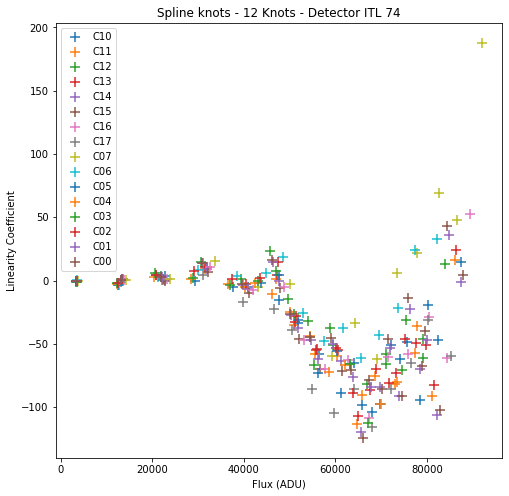

In [18]:
expId=3021120700200
camera = butler.get('camera', instrument='LSSTCam')
det = 74
lin = butler.get('linearizer', detector=det, exposure=expId, instrument='LSSTCam')
plt.figure(figsize=(8,8))
plt.subplot(1,1,1)
plt.title("Spline knots - 12 Knots - Detector ITL %d"%det)
plt.xlabel("Flux (ADU)")
plt.ylabel("Linearity Coefficient")

offset = 0.0
for it, amp in enumerate(camera[0].getAmplifiers()):
    centers, values = np.split(lin.linearityCoeffs[amp.getName()], 2)
    plt.scatter(centers, values + it * offset, marker='+', s=100, label=f"{amp.getName()}")
    #print(amp.getName(), centers, values)
    #break
plt.legend()
#plt.savefig("/repo/main/u/jcalderong/reca/ptc_13144_spline12/Spline_Knots_ITL_Det74_29Jul22.png")

I have ran this for several numers of knots. By saving the average residual for flux>10000 we can generate a plot like the fllowing:

In [23]:
Knots=np.array([10,11,12,13,14,15,20])
Avg_res74=np.array([0.22220425, 0.22595747, 0.21474993, 0.23920198, 0.24968921, 0.23708466, 0.29596893])
AR74_NESK=0.3939526282963589 #Not Equally Spaced Knots average residual

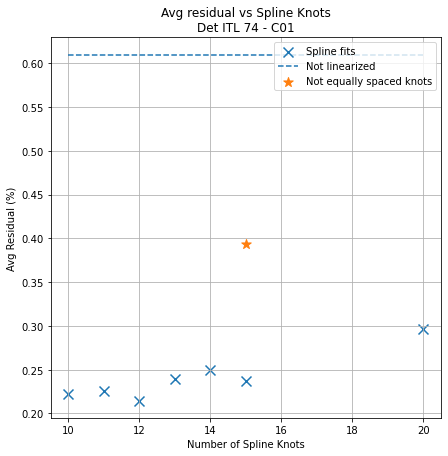

In [25]:
plt.figure(figsize=(7,7))
plt.title("Avg residual vs Spline Knots\nDet ITL 74 - C01")
plt.scatter(Knots, Avg_res74, marker='x', s=100, label='Spline fits')
plt.hlines(0.6098483789768816,10,20,ls='dashed',label='Not linearized')
plt.scatter(15,AR74_NESK, marker='*', s=100, label='Not equally spaced knots')
plt.xlabel("Number of Spline Knots")
plt.ylabel("Avg Residual (%)")
plt.legend()
plt.grid()
plt.savefig('AvgResvsKnots_74')
plt.show()

Here we can see that linearizing is crucial for improving the quality of the responses of the detector amps. The sweetspot seems to be around 12 spline knots. With the help of Craig Lage we ran a linearizer with 15 not-equally spaced knots, more clustered towards between 40000 and 80000 ADU.

We see that the clustering method to not be very effective as we implemented it but further tests are required with different number of knots and playing around with the clustering around the ~55000 ADU bump.